In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
from scipy.spatial import Delaunay, Voronoi
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
grid_map  = np.loadtxt("grid_map3.txt", dtype=float)

In [3]:
obstacle_coords = np.argwhere(grid_map == 1)
obstacle_points = np.array([[(x[0] + 0.5), (x[1] + 0.5)] for x in obstacle_coords])

In [ ]:
tri = Delaunay(obstacle_points)

vor = Voronoi(obstacle_points)

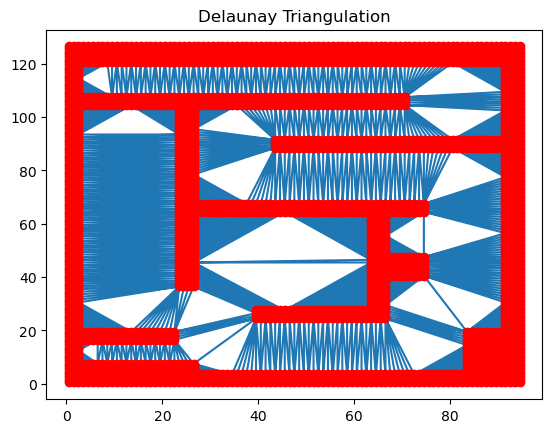

In [ ]:
# 可视化 Delaunay 三角剖分
plt.figure()
plt.triplot(obstacle_points[:, 0], obstacle_points[:, 1], tri.simplices)
plt.plot(obstacle_points[:, 0], obstacle_points[:, 1], 'ro') 
plt.title('Delaunay Triangulation')
plt.show()

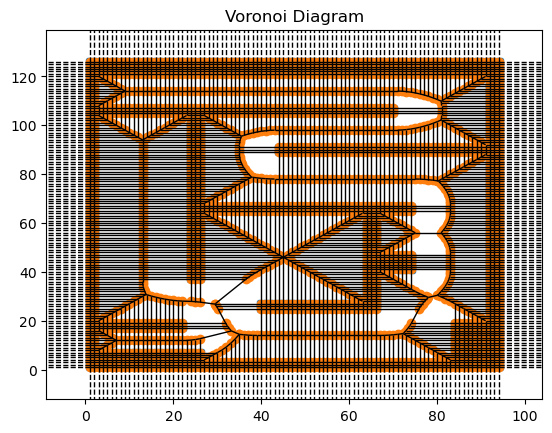

In [6]:
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
ax.set_title('Voronoi Diagram')
plt.show()

In [ ]:
def create_adjacency_matrix(vor):
    num_vertices = len(vor.vertices)
    
    # 初始化邻接矩阵
    adjacency_matrix = np.zeros((num_vertices, num_vertices))

    # 遍历所有 Voronoi 边
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # 跳过无穷远的边
        i, j = ridge
        distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])

        # 填充邻接矩阵
        adjacency_matrix[i, j] = distance
        adjacency_matrix[j, i] = distance  # 对称填充

    return adjacency_matrix

# 创建邻接矩阵
adjacency_matrix = create_adjacency_matrix(vor)
print("\nAdjacency Matrix:\n", adjacency_matrix)
print(adjacency_matrix.shape)


Adjacency Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
(3278, 3278)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot(vor, valid_vertices=None, new_adjacency_matrix=None, vertex_map=None, show=False, tpath=[-1], Apath=[-1], show_Ipath=False, show_Apath=False):
    # 如果没有提供 valid_vertices，则默认使用 vor.vertices 中的所有顶点
    if valid_vertices is None:
        valid_vertices = list(range(len(vor.vertices)))
    
    # 如果没有提供 new_adjacency_matrix，则构建一个基于 vor.ridge_vertices 的完整邻接矩阵
    if new_adjacency_matrix is None:
        num_vertices = len(vor.vertices)
        new_adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=float)
        
        # 根据 vor.ridge_vertices 构建完整邻接矩阵
        for ridge in vor.ridge_vertices:
            if -1 in ridge:
                continue  # 跳过无穷远的边
            i, j = ridge
            distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])
            new_adjacency_matrix[i, j] = distance
            new_adjacency_matrix[j, i] = distance  # 对称填充

    # 如果没有提供 vertex_map，则创建一个恒等映射，假设所有顶点有效
    if vertex_map is None:
        vertex_map = {i: i for i in valid_vertices}

    # 创建绘图区域
    fig, ax = plt.subplots(figsize=(12, 8))  # 设置适当大小
    reverse_vertex_map = {v: k for k, v in vertex_map.items()}

    # 绘制有效的 Voronoi 边
    for i in range(new_adjacency_matrix.shape[0]):
        for j in range(i + 1, new_adjacency_matrix.shape[1]):
            if new_adjacency_matrix[i, j] > 0:  # 如果两个有效顶点之间有连接
                # 使用 reverse_vertex_map 将新的索引映射回原始顶点索引
                original_i = reverse_vertex_map[i]
                original_j = reverse_vertex_map[j]
                # 使用原始顶点的坐标绘制边
                ax.plot([vor.vertices[original_i][1], vor.vertices[original_j][1]],
                        [vor.vertices[original_i][0], vor.vertices[original_j][0]],
                        color='blue', linewidth=0.8)

    # 绘制过滤后的 Voronoi 点（绿色）
    filtered_vertices = vor.vertices[valid_vertices]
    ax.plot(filtered_vertices[:, 1], filtered_vertices[:, 0], 'o', color='green', label='Filtered Voronoi Points', markersize=4)

    # 绘制关键节点
    if tpath[0] != -1:
        important_vertices = []
        for i in tpath:
            t_tans = [k for k, v in vertex_map.items() if v == i]
            if t_tans:  # 确保找到匹配的索引
                triple = vor.vertices[t_tans[0]]  # 使用第一个匹配的索引
                important_vertices.append(triple)  # 添加到重要顶点列表中
        important_vertices = np.array(important_vertices)
        ax.plot(important_vertices[:, 1], important_vertices[:, 0], 'o', color='red', label='Important Voronoi Points', markersize=4)

    # 绘制Astar路径
    if show_Apath and Apath[0] != -1:
        for i in range(len(Apath) - 1):
            start_idx = valid_vertices[Apath[i]]
            end_idx = valid_vertices[Apath[i + 1]]
            start = vor.vertices[start_idx]
            end = vor.vertices[end_idx]
            ax.plot([start[1], end[1]], [start[0], end[0]], color='pink', linewidth=2, label='Astar Path' if i == 0 else "")

    # 绘制关键路径
    if show_Ipath and tpath[0] != -1:
        for i in range(len(tpath) - 1):
            start_idx = valid_vertices[tpath[i]]
            end_idx = valid_vertices[tpath[i + 1]]
            start = vor.vertices[start_idx]
            end = vor.vertices[end_idx]
            ax.plot([start[1], end[1]], [start[0], end[0]], color='red', linewidth=2, label='Key Path' if i == 0 else "")

    # 为每个绿色点显示它在 vor.vertices 中的索引
    if show:
        for idx in valid_vertices:
            vertex = vor.vertices[idx]
            ax.text(vertex[1], vertex[0], str(idx), fontsize=8, ha='center', color='purple')

    # 绘制障碍物方块
    if obstacle_points is not None:
        for obstacle in obstacle_points:
            ax.add_patch(plt.Rectangle((obstacle[1] - 0.5, obstacle[0] - 0.5), 1, 1, color='black'))

    # 设置坐标轴范围
    ax.set_xlim(-0.1, grid_map.shape[1] + 0.1)
    ax.set_ylim(-0.1, grid_map.shape[0] + 0.1)

    # 设置标题和标签
    ax.set_title("Path planning based on the Voronoi skeleton", fontsize=16)
    ax.set_xlabel("X Coordinate", fontsize=12)
    ax.set_ylabel("Y Coordinate", fontsize=12)

    # 调整图例位置，在图外显示
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # 调整布局，防止裁剪
    plt.tight_layout()

    # 显示图形
    plt.show()

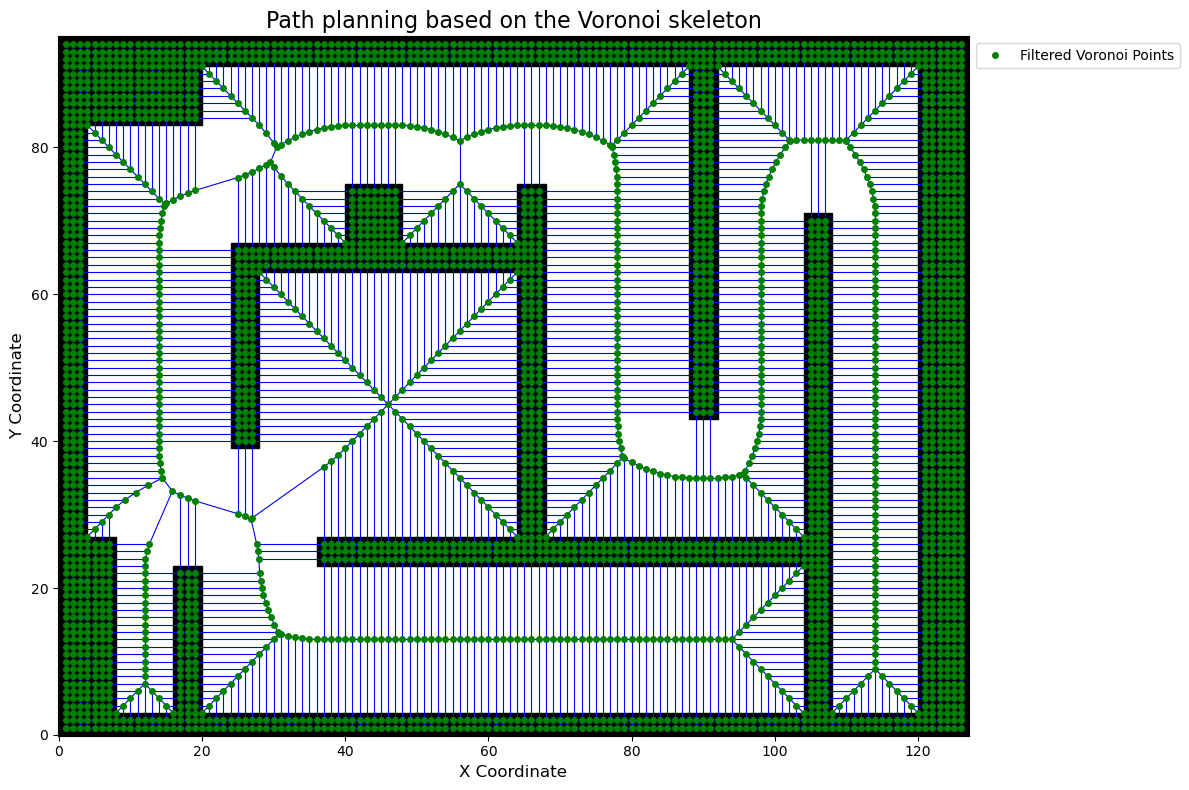

In [9]:
plot(vor)

In [10]:
m_xl = 0
m_yl = 0
resolution = 1
threshold = np.sqrt(2) / 2 * resolution

In [11]:
def convert_to_grid_coordinates(x, y, m_xl, m_yl, resolution):
    x_g = int(np.floor((x - m_xl) / resolution))
    y_g = int(np.floor((y - m_yl) / resolution))
    return x_g, y_g

In [12]:
def filter_obstacle_vertices3(vor, grid_map, m_xl, m_yl, resolution):
    valid_vertices = []
    vertex_map = {}

    # 找到所有有效的顶点，并创建一个映射
    for i, vertex in enumerate(vor.vertices):
        x_g, y_g = convert_to_grid_coordinates(vertex[0], vertex[1], m_xl, m_yl, resolution)
        # 检查顶点是否在障碍物内
        if (0 <= x_g < grid_map.shape[0] and 0 <= y_g < grid_map.shape[1]) and grid_map[x_g, y_g] != 1:
            vertex_map[i] = len(valid_vertices)  # 映射原始索引到新的有效索引
            valid_vertices.append(i)  # 保留不在障碍物内部的顶点

    # 创建新的邻接矩阵，只包含有效顶点
    num_valid_vertices = len(valid_vertices)
    new_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)

    # 遍历所有 Voronoi 边，只保留有效顶点之间的边
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # 跳过无穷远的边

        i, j = ridge  # 获取边的两个顶点的索引
        if i in vertex_map and j in vertex_map:  # 仅当两个顶点都有效时保留该边
            new_i = vertex_map[i]
            new_j = vertex_map[j]
            # 计算两个有效顶点之间的距离
            distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])
            new_adjacency_matrix[new_i, new_j] = distance
            new_adjacency_matrix[new_j, new_i] = distance  # 对称填充

    # 返回有效顶点索引、新的邻接矩阵以及原始索引到有效索引的映射
    return valid_vertices, new_adjacency_matrix, vertex_map

In [13]:
valid_vertices, filtered_adjacency_matrix, vertex_map = filter_obstacle_vertices3(vor, grid_map, m_xl, m_yl, resolution)

print("有效顶点索引:", valid_vertices)
print("过滤后的邻接矩阵:\n", filtered_adjacency_matrix)
print("过滤后的邻接矩阵尺寸:\n",filtered_adjacency_matrix.shape)
print("原始索引到有效索引的映射:\n", vertex_map)

有效顶点索引: [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 27, 32, 33, 36, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 59, 60, 61, 64, 65, 69, 70, 71, 75, 88, 90, 91, 92, 93, 96, 97, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 124, 125, 129, 133, 134, 135, 136, 138, 139, 147, 148, 156, 157, 158, 163, 164, 165, 171, 174, 178, 179, 182, 183, 186, 187, 188, 189, 190, 192, 201, 202, 203, 207, 208, 211, 212, 220, 224, 225, 236, 237, 238, 239, 240, 245, 248, 254, 256, 257, 260, 261, 263, 264, 267, 268, 271, 272, 273, 274, 275, 276, 281, 282, 288, 289, 310, 313, 315, 320, 336, 341, 342, 346, 347, 349, 350, 352, 353, 356, 357, 364, 365, 367, 368, 374, 376, 377, 389, 396, 397, 399, 400, 402, 404, 405, 408, 409, 411, 412, 413, 414, 419, 420, 421, 422, 424, 433, 434, 440, 451, 452, 453, 458, 480, 481, 482, 490, 492, 493, 499, 500, 501, 502, 509, 513, 514, 516, 520, 521, 522, 523, 524, 530, 531, 534, 535, 556, 557, 559, 560, 561, 562, 563, 569, 577, 578, 579, 582, 583, 589, 593, 602, 6

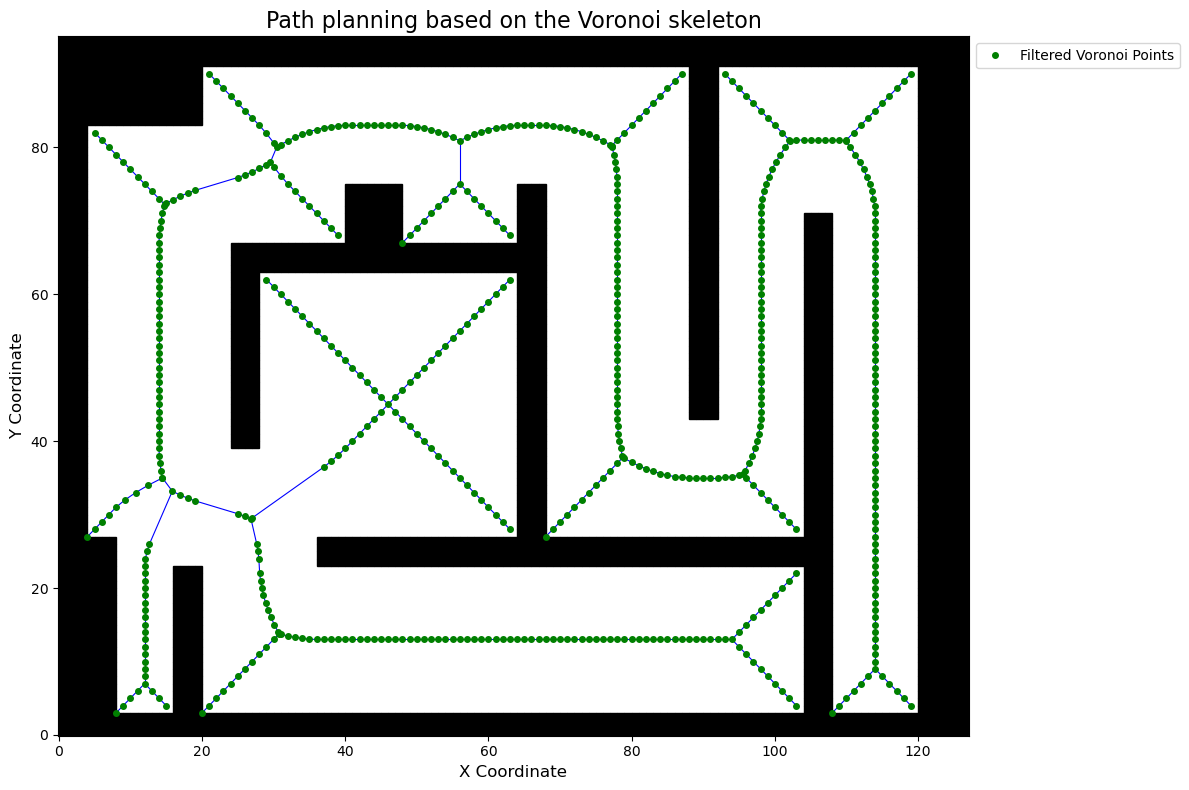

In [14]:
plot(vor,valid_vertices,filtered_adjacency_matrix,vertex_map)

In [15]:
def filter_voronoi_edges1(vor, grid_map, vertex_map, resolution, threshold):
    num_valid_vertices = len(vertex_map)
    updated_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)
    
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # 跳过无穷远的边
        
        i, j = ridge
        if i in vertex_map and j in vertex_map:
            p1, p2 = vor.vertices[i], vor.vertices[j]
            d_obs_min = float('inf')
            
            # 找到包含该边的最小栅格范围
            min_x, max_x = int(np.floor(min(p1[0], p2[0]) / resolution)), int(np.ceil(max(p1[0], p2[0]) / resolution))
            min_y, max_y = int(np.floor(min(p1[1], p2[1]) / resolution)), int(np.ceil(max(p1[1], p2[1]) / resolution))
        
            # 计算每个障碍物中心点到边的最小距离
            for y in range(min_y, max_y + 1):
                for x in range(min_x, max_x + 1):
                    if grid_map[x, y] == 1:  # 障碍物网格
                        p_i = np.array([(x + 0.5) * resolution, (y + 0.5) * resolution])
                        d_obs = np.abs(np.linalg.det([p2 - p1, p_i - p1]) / np.linalg.norm(p2 - p1))
                        d_obs_min = min(d_obs_min, d_obs)
            # 判断最小距离是否超过阈值
            if d_obs_min >= threshold:
                new_i = vertex_map[i]
                new_j = vertex_map[j]
                distance = np.linalg.norm(p1 - p2)
                updated_adjacency_matrix[new_i, new_j] = distance
                updated_adjacency_matrix[new_j, new_i] = distance  # 对称填充
                
    return updated_adjacency_matrix

In [16]:
def filter_voronoi_edges(vor, grid_map, vertex_map, resolution, threshold):
    num_valid_vertices = len(vertex_map)
    updated_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)
    
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # 跳过无穷远的边
        
        i, j = ridge
        if i in vertex_map and j in vertex_map:
            p1, p2 = vor.vertices[i], vor.vertices[j]
            edge_crosses_obstacle = False  # 标记是否穿过障碍物
            
            # 找到包含该边的最小栅格范围
            min_x, max_x = int(np.floor(min(p1[0], p2[0]) / resolution)), int(np.ceil(max(p1[0], p2[0]) / resolution))
            min_y, max_y = int(np.floor(min(p1[1], p2[1]) / resolution)), int(np.ceil(max(p1[1], p2[1]) / resolution))
        
            # 检查该边是否穿过障碍物
            for y in range(min_y, max_y + 1):
                for x in range(min_x, max_x + 1):
                    if grid_map[x, y] == 1:  # 障碍物网格
                        # 计算障碍物中心到边的距离
                        p_i = np.array([(x + 0.5) * resolution, (y + 0.5) * resolution])
                        d_obs = np.abs(np.linalg.det([p2 - p1, p_i - p1]) / np.linalg.norm(p2 - p1))
                        
                        # 如果距离小于某个数值，认为边穿过障碍物
                        if d_obs < threshold - 0.1:
                            edge_crosses_obstacle = True
                            break
                if edge_crosses_obstacle:
                    break
            
            # 如果边没有穿过任何障碍物，则添加到邻接矩阵中
            if not edge_crosses_obstacle:
                new_i = vertex_map[i]
                new_j = vertex_map[j]
                distance = np.linalg.norm(p1 - p2)
                updated_adjacency_matrix[new_i, new_j] = distance
                updated_adjacency_matrix[new_j, new_i] = distance  # 对称填充
                
    return updated_adjacency_matrix

In [17]:
updated_adjacency_matrix = filter_voronoi_edges(vor,grid_map,vertex_map,resolution,threshold)
print(updated_adjacency_matrix.shape)
np.savetxt("updated_adjacency_matrix.txt", updated_adjacency_matrix, fmt="%f", delimiter=" ")

(604, 604)


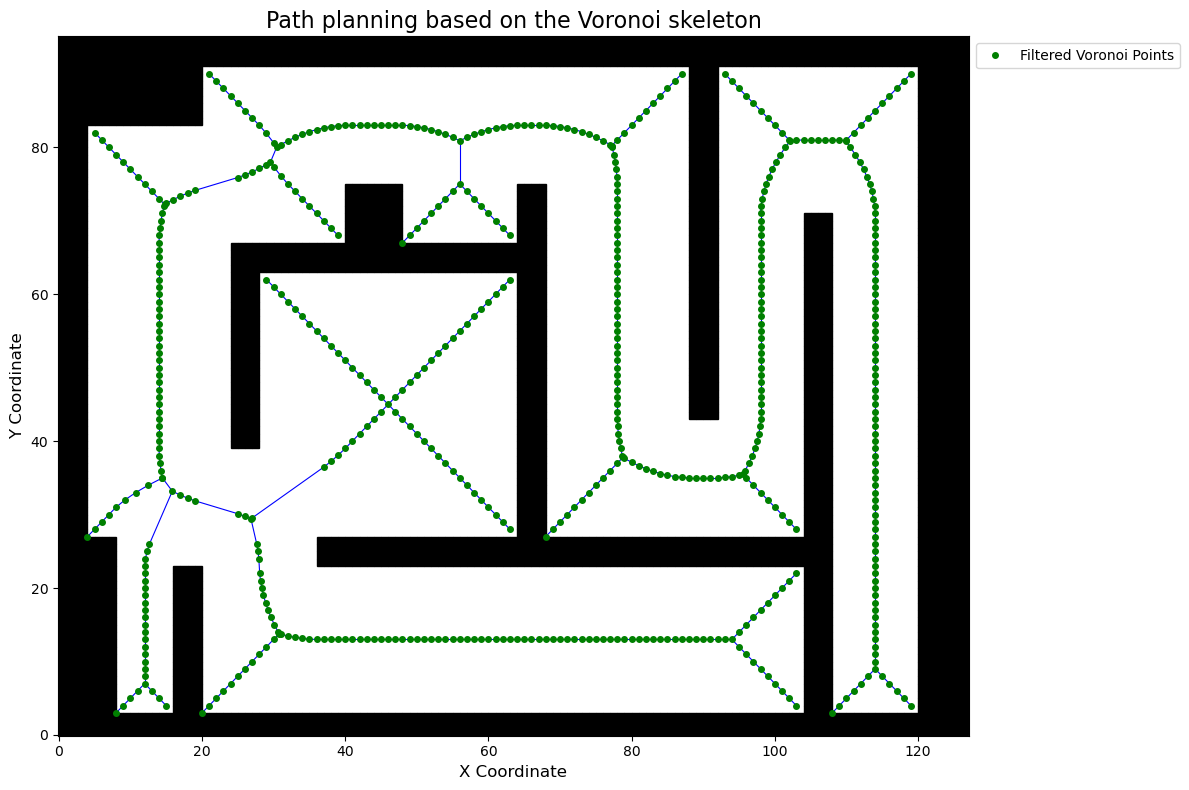

In [18]:
plot(vor,valid_vertices,updated_adjacency_matrix,vertex_map)

In [ ]:
def remove_redundant_vertices(vor, valid_vertices, new_adjacency_matrix, vertex_map):
    pruned_vertices = []  # 用于保存删除冗余后的顶点
    trans_map = {}  # 用于记录映射关系：原始顶点 -> 新的有效顶点
    finally_map = {}  # 用于记录原始顶点到最终顶点的映射
    pruned_adjacency_matrix = new_adjacency_matrix.copy()  # 初始化邻接矩阵副本
    # 遍历每个有效顶点
    for i, vertex in enumerate(valid_vertices):
        neighbors = np.nonzero(pruned_adjacency_matrix[i])[0]  # 获取当前顶点的邻居
        if len(neighbors) == 2:  # 如果该顶点的度为 2，说明是一个内部顶点
            # 检查是否共线
            v1 = vor.vertices[valid_vertices[neighbors[0]]] - vor.vertices[vertex]
            v2 = vor.vertices[valid_vertices[neighbors[1]]] - vor.vertices[vertex]
            v1_3d = np.append(v1, 0)  # 将二维坐标转换为三维，方便计算叉积
            v2_3d = np.append(v2, 0)
            if np.isclose(np.cross(v1_3d, v2_3d)[-1], 0):  # 如果共线，删除该顶点
                # 合并邻接点
                pruned_adjacency_matrix[neighbors[0], neighbors[1]] = pruned_adjacency_matrix[i, neighbors[0]] + pruned_adjacency_matrix[i, neighbors[1]]
                pruned_adjacency_matrix[neighbors[1], neighbors[0]] = pruned_adjacency_matrix[neighbors[0], neighbors[1]]  # 对称填充
                # 将该行和列置零，表示删除当前顶点
                pruned_adjacency_matrix[i, :] = 0
                pruned_adjacency_matrix[:, i] = 0
                continue  # 跳过该顶点，继续遍历剩余顶点
        trans_map[i] = len(pruned_vertices)  # 记录原始顶点到新顶点的映射
        pruned_vertices.append(vertex)  # 保留该顶点
    # 更新原始顶点到有效顶点的映射
    for original_index, valid_index in vertex_map.items():
        if valid_index in trans_map:
            final_index = trans_map[valid_index]  # 获取映射后的最终索引
            finally_map[original_index] = final_index  # 保存映射关系
    # 构建新的邻接矩阵
    num_final_vertices = len(pruned_vertices)  # 最终顶点的数量
    final1_adjacency_matrix = np.zeros((num_final_vertices, num_final_vertices), dtype=float)
    # 遍历有效顶点，重新构建邻接矩阵
    for i in range(num_final_vertices):
        for j in range(i + 1, num_final_vertices):
            original_i = [k for k, v in trans_map.items() if v == i][0]  # 从 trans_map 找到第三次步结束顶点与第一步结束顶点之间的索引
            original_j = [k for k, v in trans_map.items() if v == j][0]
            # 如果原始顶点之间有连接，则在新的邻接矩阵中添加边
            if pruned_adjacency_matrix[original_i, original_j] > 0:
                # 使用原始顶点的坐标计算距离
                trans_i = [k for k, v in finally_map.items() if v == i][0]
                trans_j = [k for k, v in finally_map.items() if v == j][0]
                distance = np.linalg.norm(vor.vertices[trans_i] - vor.vertices[trans_j])
                final1_adjacency_matrix[i, j] = distance
                final1_adjacency_matrix[j, i] = distance
    return pruned_vertices, final1_adjacency_matrix, finally_map

In [20]:
pruned_vertices, final1_adjacency_matrix,final_map = remove_redundant_vertices(vor,valid_vertices,updated_adjacency_matrix,vertex_map)
np.savetxt("pruned_adjacency_matrix1.txt", final1_adjacency_matrix, fmt="%f", delimiter=" ")

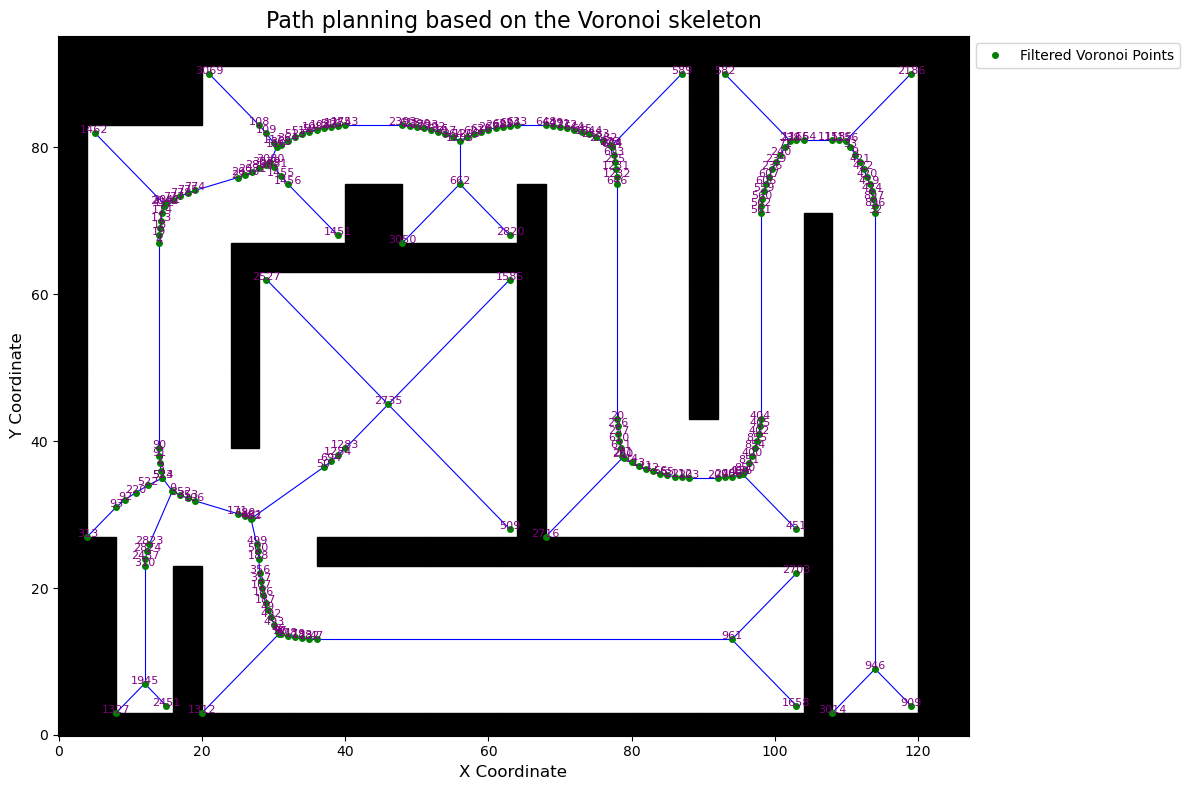

In [21]:
plot(vor,pruned_vertices,final1_adjacency_matrix,final_map,show=True)

In [22]:
from queue import PriorityQueue
def astar_path(start, goal, pruned_vertices, adjacency_matrix):
    path = []
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {start: None}
    g_score = {v: float('inf') for v in range(len(pruned_vertices))}
    g_score[start] = 0
    f_score = {v: float('inf') for v in range(len(pruned_vertices))}
    f_score[start] = np.linalg.norm(pruned_vertices[start] - pruned_vertices[goal])

    closed_set = set()  # 初始化封闭集

    while not open_set.empty():
        _, current = open_set.get()
        if current == goal:
            # 回溯路径
            while current is not None:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        closed_set.add(current)  # 将当前节点加入封闭集

        for neighbor, distance in enumerate(adjacency_matrix[current]):
            if distance > 0 and neighbor not in closed_set:  # 只有在封闭集中没有的邻居才处理
                tentative_g_score = g_score[current] + distance
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + np.linalg.norm(pruned_vertices[neighbor] - pruned_vertices[goal])
                    open_set.put((f_score[neighbor], neighbor))

    return path


In [23]:
def extract_key_points1(Apath, grid_map, dth, pruned_vertices, vor):
    tpath = []  # 初始化关键顶点路径
    i = 0
    tpath.append(Apath[i])  # 将起点加入 tpath

    while i < len(Apath) - 1:
        # 获取上一个关键节点的坐标 (tpath[-1]) 和当前待检查的节点 jv
        S_index = pruned_vertices[tpath[-1]]
        S = vor.vertices[S_index]

        j = i + 1
        while j < len(Apath):
            # 获取下一个待检查节点 jv 的坐标
            jv_index = pruned_vertices[Apath[j]]
            jv = vor.vertices[jv_index]

            # 步骤 (3)：检查上一个关键节点 S 和 jv 之间的路径是否存在障碍物
            min_x, max_x = int(min(S[0], jv[0])), int(max(S[0], jv[0]))
            min_y, max_y = int(min(S[1], jv[1])), int(max(S[1], jv[1]))

            obstacle_found = False
            for x in range(min_x, max_x + 1):
                for y in range(min_y, max_y + 1):
                    if grid_map[x, y] == 1:  # 障碍物网格
                        obstacle_found = True
                        break
                if obstacle_found:
                    break

            # 如果上一个关键节点和 jv 之间没有障碍物，则继续剔除冗余节点
            if not obstacle_found:
                j += 1
            else:
                # 步骤 (4)：如果存在障碍物，计算路径与障碍物的最小距离 dmin
                dmin = float('inf')
                for x in range(min_x, max_x + 1):
                    for y in range(min_y, max_y + 1):
                        if grid_map[x, y] == 1:
                            # 计算障碍物中心到路径的最小距离
                            p_i = np.array([x + 0.5, y + 0.5])  # 障碍物中心坐标
                            distance_to_path = np.abs(np.linalg.det([jv - S, p_i - S]) / np.linalg.norm(jv - S))
                            dmin = min(dmin, distance_to_path)

                # 判断 dmin 是否小于阈值 dth
                if dmin > dth:
                    # 障碍物离路径足够远，继续剔除冗余节点
                    j += 1
                else:
                    # 障碍物靠近路径，将 j-1 节点作为关键节点，加入 tpath
                    tpath.append(Apath[j - 1])
                    i = j - 1  # 更新 i 到新的关键节点位置
                    break

        # 更新起点为上一个关键节点
        i = j

    # 将终点加入 tpath
    tpath.append(Apath[-1])
    return tpath

In [24]:
def extract_key_points(Apath, grid_map, dth, pruned_vertices, vor):
    tpath = []  # 初始化关键顶点路径
    i = 0
    tpath.append(Apath[i])  # 将起点加入 tpath

    while i < len(Apath) - 1:
        # 获取上一个关键节点的坐标 (tpath[-1]) 和当前待检查的节点 jv
        S_index = pruned_vertices[tpath[-1]]
        S = vor.vertices[S_index]

        j = i + 1
        while j < len(Apath):
            # 获取下一个待检查节点 jv 的坐标
            jv_index = pruned_vertices[Apath[j]]
            jv = vor.vertices[jv_index]

            # 检查路径上是否有障碍物
            min_x, max_x = int(min(S[0], jv[0])), int(max(S[0], jv[0]))
            min_y, max_y = int(min(S[1], jv[1])), int(max(S[1], jv[1]))

            # 初始化变量，用于检测路径是否满足无障碍和最小距离要求
            no_obstacle_found = True
            min_distance_to_obstacle = float('inf')

            # 遍历路径上的所有网格，检测是否有障碍物
            for x in range(min_x, max_x + 1):
                for y in range(min_y, max_y + 1):
                    if 0 <= x < grid_map.shape[0] and 0 <= y < grid_map.shape[1]:  # 防止越界
                        if grid_map[x, y] == 1:  # 当前网格为障碍物
                            no_obstacle_found = False
                            break
                if not no_obstacle_found:
                    break

            # 如果路径上存在障碍物，则停止当前路径段检查
            if not no_obstacle_found:
                tpath.append(Apath[j - 1])  # 提取当前路径段的关键点
                i = j - 1
                break

            # 检查路径与周围障碍物的最短距离
            for x in range(min_x - 3, max_x + 3):  # 扩展一格范围
                for y in range(min_y - 3, max_y + 3):  # 扩展一格范围
                    if 0 <= x < grid_map.shape[0] and 0 <= y < grid_map.shape[1]:  # 防止越界
                        if grid_map[x, y] == 1:  # 当前网格为障碍物
                            # 计算障碍物到路径的最短距离
                            p_i = np.array([x + 0.5, y + 0.5])  # 障碍物中心点坐标
                            distance_to_path = np.abs(np.linalg.det([jv - S, p_i - S]) / np.linalg.norm(jv - S))
                            min_distance_to_obstacle = min(min_distance_to_obstacle, distance_to_path)

            # 如果路径与周边障碍物的最短距离小于阈值，则停止当前路径段检查
            if min_distance_to_obstacle < dth:
                tpath.append(Apath[j - 1])  # 提取当前路径段的关键点
                i = j - 1
                break

            # 如果路径满足所有条件，则继续检查下一个节点
            j += 1

        # 更新起点为上一个关键节点
        i = j

    # 将终点加入 tpath
    tpath.append(Apath[-1])
    return tpath


In [27]:
start_p = 946  # 起点在 pruned_vertices 中的索引
goal_p = 961  # 终点在 pruned_vertices 中的索引
dth = 3  # 距离阈值

start = [v for k, v in final_map.items() if k == start_p][0]
goal = [v for k, v in final_map.items() if k == goal_p][0]
# 执行 A*算法以获得初始路径
Apath = astar_path(start, goal, pruned_vertices, final1_adjacency_matrix)
true_Apath = []
true_Tpath = []
for i in Apath: 
    point = [k for k, v in final_map.items() if v == i]
    #pruned_vertices[Apath[i]]
    true_Apath.append(point)
# 提取关键顶点
tpath = extract_key_points(Apath, grid_map, dth, pruned_vertices,vor)
for i in tpath: 
    point = [k for k, v in final_map.items() if v == i]
    true_Tpath.append(point)

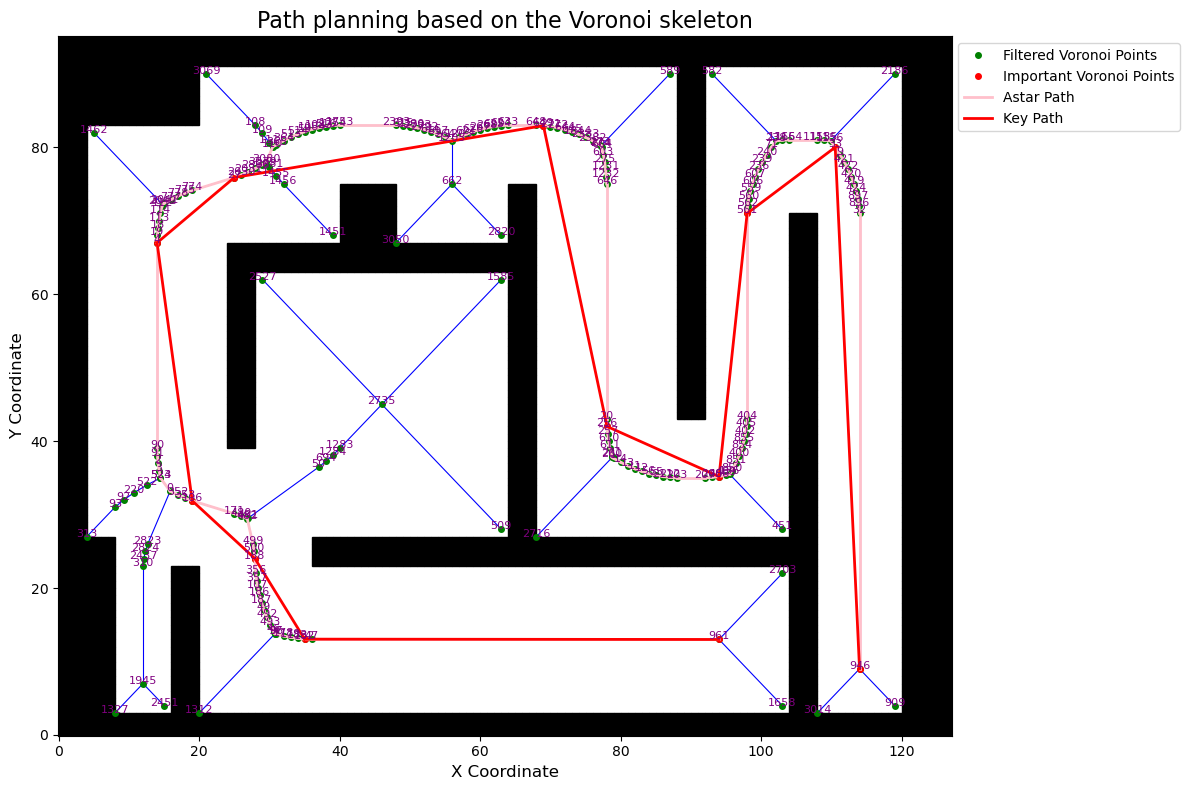

In [28]:
plot(vor,pruned_vertices,final1_adjacency_matrix,final_map,show = True,tpath=tpath,Apath=Apath , show_Ipath=True,show_Apath= True)

In [29]:
row = np.size(grid_map,0)#行数
col = np.size(grid_map,1)#列数
grid_size = (int(row / resolution), int(col / resolution))  # 栅格地图大小
resolution = 1 #每格表示一个单位 obstacle_points

In [30]:
print(row,col)

95 127


In [31]:
true_Tpath
flat_list = np.array(true_Tpath).flatten().tolist()
print(flat_list)

[946, 33, 561, 408, 256, 649, 27, 4, 106, 188, 182, 961]


In [32]:
key_path_edges = []
for i in range(1 , len(tpath) - 1):
    key_path_edges.append((flat_list[i],flat_list[i + 1]))
print(key_path_edges)

[(33, 561), (561, 408), (408, 256), (256, 649), (649, 27), (27, 4), (4, 106), (106, 188), (188, 182), (182, 961)]


In [34]:
important_v = []
for i in range(1 , len(tpath)):
    tuple_arr = tuple(vor.vertices[true_Tpath[i]])
    int_arr = tuple(np.array(tuple_arr).astype(int))
    important_v.append(int_arr)
converted_v = [tuple(arr[0]) for arr in important_v]
print(converted_v)
np.save('data.npy', converted_v)

[(80, 110), (71, 98), (35, 94), (42, 78), (82, 69), (75, 25), (67, 14), (31, 19), (24, 27), (13, 35), (13, 94)]


In [35]:
def bresenham_line(x1, y1, x2, y2):
    """
    使用 Bresenham 算法生成直线的栅格坐标。

    Args:
        x1, y1: 起点坐标。
        x2, y2: 终点坐标。

    Returns:
        rr, cc: 直线经过的栅格行列坐标列表。
    """
    rr, cc = [], []
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx, sy = (1 if x1 < x2 else -1), (1 if y1 < y2 else -1)
    err = dx - dy

    while True:
        rr.append(x1)
        cc.append(y1)
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return rr, cc

In [ ]:
def plot_to_grid(vor, key_path_edges, obstacles, grid_size, resolution):
    # 初始化栅格地图，默认全为可通行区域（0）
    grid_map = np.zeros(grid_size, dtype=int)

    # 绘制障碍物到栅格地图中
    for obstacle in obstacles:
        x, y = (np.array(obstacle) / resolution).astype(int)
        if 0 <= x < grid_size[0] and 0 <= y < grid_size[1]:  # 防止越界
            grid_map[x, y] = 1  # 障碍物标记为 1

    # 绘制骨架关键路径到栅格地图中
    for edge in key_path_edges:
        start_index, end_index = edge
        start = vor.vertices[start_index]
        end = vor.vertices[end_index]
        
        # 将路径点从实际坐标映射到栅格坐标
        x1, y1 = (start / resolution).astype(int)
        x2, y2 = (end / resolution).astype(int)
        
        # 使用 Bresenham 算法绘制线段到栅格中
        rr, cc = bresenham_line(x1, y1, x2, y2)
        for r, c in zip(rr, cc):
            if 0 <= r < grid_size[0] and 0 <= c < grid_size[1]:  # 防止越界
                if grid_map[r, c] != 1:  # 避免覆盖障碍物
                    grid_map[r, c] = 2  # 关键路径标记为 2

    return grid_map

In [37]:

grid_map_final = plot_to_grid(vor,key_path_edges,obstacle_points,grid_size,resolution)
np.savetxt("grid_map_final2.txt", grid_map_final, fmt="%d", delimiter=" ")

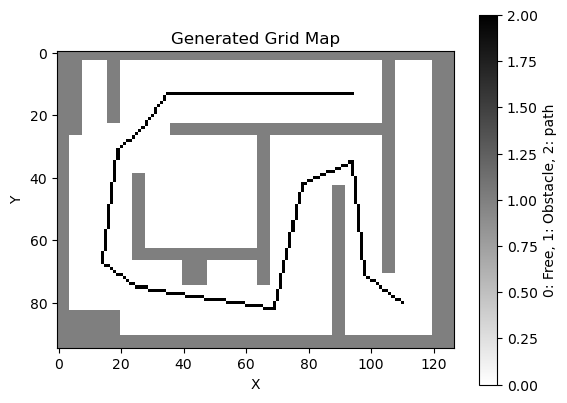

In [38]:
import matplotlib.pyplot as plt

plt.imshow(grid_map_final, cmap='gray_r')
plt.title("Generated Grid Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="0: Free, 1: Obstacle, 2: path")
plt.show()